# Understanding LIME (Local Interpretable Model-agnostic Explainer)


## References

Original LIME Paper

* ["Why Should I Trust You?" Explaining the Predictions of Any Classifier](https://arxiv.org/pdf/1602.04938.pdf)


Book Chapters

* https://ema.drwhy.ai/LIME.html#ref-imlRPackage
* https://christophm.github.io/interpretable-ml-book/lime.html

Implementations

* Python https://github.com/marcotcr/lime
* R https://github.com/thomasp85/lime

Other references

* https://arxiv.org/pdf/2006.12302.pdf
* https://homes.cs.washington.edu/~marcotcr/blog/lime/
* https://www.oreilly.com/content/introduction-to-local-interpretable-model-agnostic-explanations-lime/
* https://cran.r-project.org/web/packages/lime/vignettes/Understanding_lime.html
* https://www.duo.uio.no/bitstream/handle/10852/74988/ideal19Final.pdf?sequence=1




## Visual Intuition behind LIME

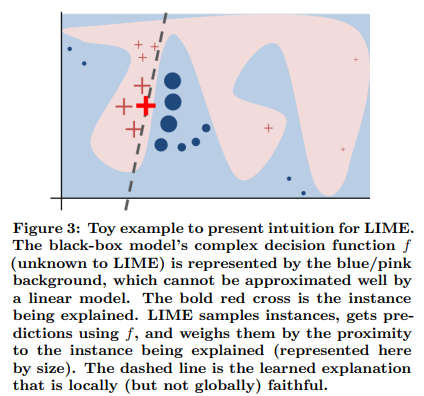

Source: https://arxiv.org/pdf/1602.04938.pdf

---

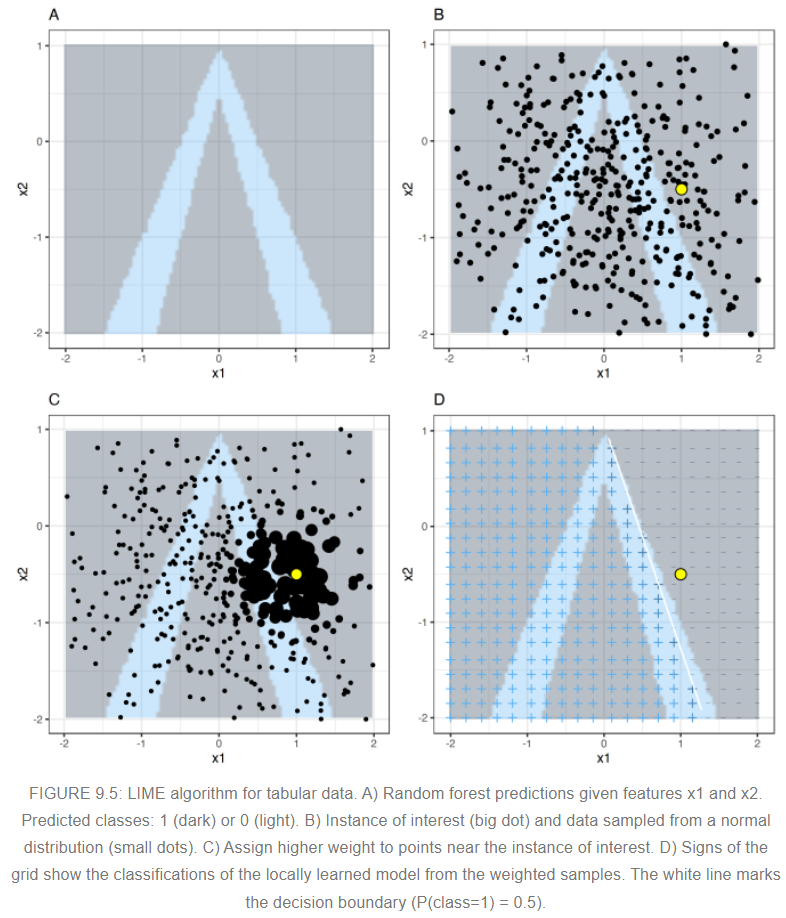

Source: https://christophm.github.io/interpretable-ml-book/lime.html

---

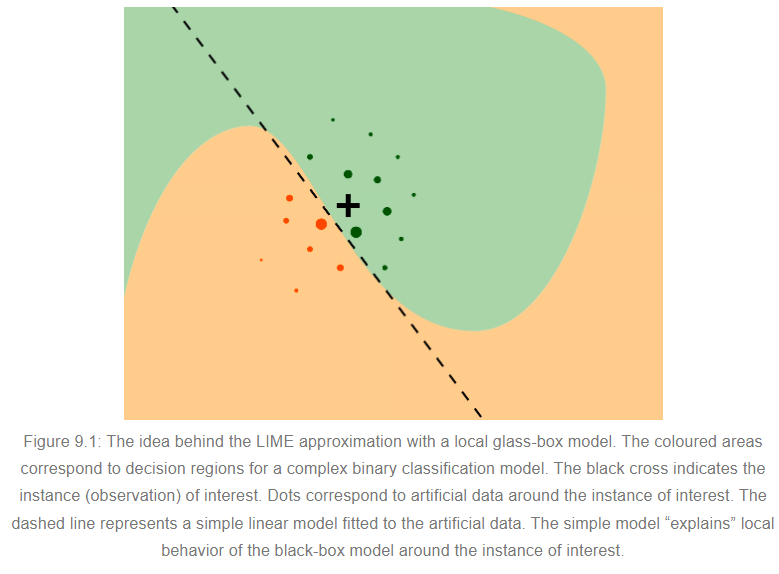

Source: https://ema.drwhy.ai/LIME.html#ref-imlRPackage

# Implementing a simplified LIME from scratch

In [2]:
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier
import lime
import lime.lime_tabular
import numpy as np
from matplotlib import pyplot as plt

## Create a dataset with non-linearily separable classes

In [3]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.1)

df = pd.DataFrame(dict(x_1 = X[:, 0], x_2 = X[:, 1], label = y))
df.head()

,x_1,x_2,label
0,0.525232,0.681557,0
1,0.510369,0.770972,0
2,1.962554,0.125929,1
3,-0.980927,0.094985,0
4,1.473713,-0.272048,1


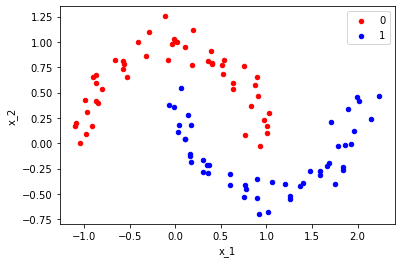

In [4]:
colors = {0: "red", 1: "blue"}
fig, ax = plt.subplots()
grouped = df.groupby("label")
for key, group in grouped:
    group.plot(ax=ax, kind="scatter", x="x_1", y="x_2", label=key, color=colors[key])
plt.show()

## Build a black box classifier 

Lime can explain individual predictions of any black box classifier. I use a Random Forest Classifier.

In [6]:
from sklearn.ensemble import RandomForestClassifier

blackbox_clf = RandomForestClassifier()
blackbox_clf.fit(X, y)

preds = blackbox_clf.predict(X)
probs = blackbox_clf.predict_proba(X)

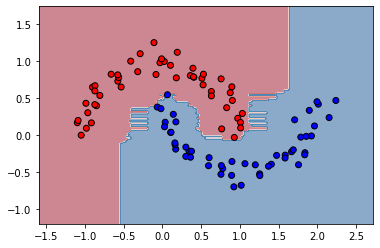

In [10]:
# Plot color-coded decision boundaries

# create mesh grid
step_size = 0.02
x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, step_size), np.arange(x2_min, x2_max, step_size))

# predict classes of our grid
Z = blackbox_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
Z[Z >= 0.5] = 1
Z[Z < 0.5] = 0

# # uncomment if you want colors to reflect predicted probability
# Z = blackbox_clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1] # Pr(Y=1|X) stored in 2nd column
# Z = Z.reshape(xx.shape)

from matplotlib.colors import ListedColormap
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(["#FF0000", "#0000FF"]), edgecolors="k")
plt.show()

## Select a single instance which we want to explain

In [49]:
# Select an instance that is close to the decision boundary, ie Pr(Y=1|x)~0.5
df["pred_label"] = preds
df["pred_proba"] = probs[:, 1]
df.head()

,x_1,x_2,label,pred_label,pred_proba
0,0.525232,0.681557,0,0,0.00
1,0.510369,0.770972,0,0,0.00
2,1.962554,0.125929,1,1,0.91
3,-0.980927,0.094985,0,0,0.02
4,1.473713,-0.272048,1,1,1.00


In [51]:
eps = 0.3
df[(df.pred_proba - 0.5).abs() <= eps]

,x_1,x_2,label,pred_label,pred_proba
19,-0.066090,0.381767,1,1,0.73
64,0.064781,0.547995,1,1,0.74
71,0.928267,-0.029134,0,0,0.36


In [58]:
idxs = df[(df.pred_proba - 0.5).abs() <= eps].sort_values("pred_proba", ascending=True).index.tolist()
idxs

[71, 19, 64]

In [60]:
i = idxs[0]
x = X[i]

print(f"to-be-explained instance i={i}: {x}")

to-be-explained instance i=71: [ 0.92826701 -0.02913398]


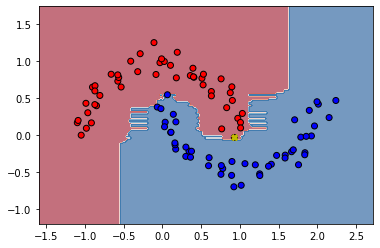

In [61]:
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(["#FF0000", "#0000FF"]), edgecolors="k")
plt.plot(x[0], x[1], "yX")
plt.show()

## Create samples around the to-be-explained instance x

In [62]:
def means_and_sdevs(X):
    """Calculates mean and standard deviation for each column of X"""
    means = np.mean(X, axis=0)
    sdevs = np.mean(X, axis=0)
    return means, sdevs

def generate_samples(x, n_samples, sdevs_of_features):
    """
    Generates a dataset of sampled observations close to the 
    to-be-explained instance x.
    """
    n_cols = len(means)
    X_around_x = np.random.normal(0, 1, n_samples*n_cols).reshape(n_samples, n_cols)
    X_around_x = X_around_x * sdevs_of_features + x
    return X_around_x

In [65]:
n_samples = 200
means, sdevs = means_and_sdevs(X)

X_x = generate_samples(x, n_samples=n_samples, sdevs_of_features=sdevs)

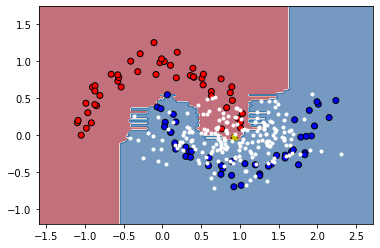

In [81]:
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(["#FF0000", "#0000FF"]), edgecolors="k")
plt.plot(x[0], x[1], "yX")
plt.plot(X_x[:, 0], X_x[:, 1], "w.")
plt.show()

## Predict each sampled instance using the black box classifier

In [67]:
preds_samples = blackbox_clf.predict(X_x)
preds_samples.shape

(200,)

## Create the dataset on which we train the glass (interpretable) classifier

In [68]:
X_glass = X_x
y_glass = preds_samples

## Calculate distance between each generated sample instance and the to-be-explained instance x

In [82]:
import scipy
def euclidean_dist(X, x):
    distances = scipy.spatial.distance.cdist(
        XA=X_x,
        XB=x.reshape(1, -1),
        metric="euclidean"
    )
    return distances.reshape(-1)

In [83]:
dists = euclidean_dist(X_x, x)
similarities = 1/dists
similarities

array([ 1.90665213,  2.6866136 ,  1.43586792,  0.87960139,  1.61392653,
        0.86433477,  1.10475029,  1.61066215,  5.12470727,  2.42722483,
        3.8644623 ,  1.70234668,  1.37983113,  1.5255504 ,  1.48516973,
        3.67012655,  3.91711312,  1.59560495,  1.47278436,  4.12202154,
        1.54749173,  0.96184285,  1.21281859,  1.48273923,  3.87162296,
        2.17346569,  2.11595684,  0.82426952,  2.10257673,  1.65847867,
        5.67425453,  1.47468781,  1.91029899,  8.34010708,  4.79943404,
        5.04726829,  1.66112856,  4.82986474,  9.0073771 ,  2.61126434,
        0.80719495,  1.75806266,  1.55564087,  7.94406405,  3.37594747,
        1.36241568,  1.5923701 ,  4.03313961,  4.80887607,  1.35255083,
        6.97217179,  1.82987171,  7.87509994,  1.51148686,  2.39548432,
        9.27897525,  5.89397864,  2.88008558, 17.63837582,  1.79062595,
        1.67666468,  1.54314765,  3.98367266,  1.71231992,  2.33440544,
        1.68021994,  3.79377102,  1.39541919,  0.95403769,  2.01

## Train glass (interpretable) classifier

Here, I use logistic regression.

In [84]:
from sklearn.linear_model import LogisticRegression

glass_clf = LogisticRegression()
glass_clf.fit(X_glass, y_glass, sample_weight=similarities)

glass_clf_preds = glass_clf.predict(X_x)

In [85]:
data_plt = pd.DataFrame(dict(x_1=X_glass[:, 0], x_2=X_glass[:, 1], label=y_glass, pred=glass_clf_preds))
data_plt.head()

,x_1,x_2,label,pred
0,1.452742,-0.031264,1,1
1,1.000966,0.335913,0,0
2,0.313612,0.298328,1,0
3,2.051250,-0.206341,1,1
4,0.308661,-0.030098,1,0


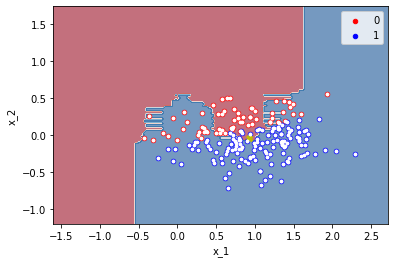

In [86]:
colors = {0: "red", 1: "blue"}
fig, ax = plt.subplots()
ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.6)
ax.plot(x[0], x[1], "yX")
grouped = data_plt.groupby("pred")
for key, group in grouped:
    group.plot(ax=ax, kind="scatter", x="x_1", y="x_2", label=key, color=colors[key])
plt.plot(data_plt.x_1, data_plt.x_2, "w.")

## Explain the instance using the interpretable logistic regression model

In [87]:
print(glass_clf.coef_, glass_clf.intercept_)

score = glass_clf.intercept_ + x[0]*glass_clf.coef_[0, 0] + x[1]*glass_clf.coef_[0, 1]
prob = (1/(1+np.exp(-score)))
prob

[[ 1.18372943 -5.71839226]] [-0.62734224]


array([0.65431802])

In [88]:
x1_coef, x2_coef = glass_clf.coef_[0]

print(f"An increase of feature x1 by 1 unit multiplies the odds of belonging to class y=1 by {round(np.exp(x1_coef), 2)}")
print(f"An increase of feature x2 by 1 unit multiplies the odds of belonging to class y=1 by {round(np.exp(x2_coef), 2)}")

An increase of feature x1 by 1 unit multiplies the odds of belonging to class y=1 by 3.27
An increase of feature x2 by 1 unit multiplies the odds of belonging to class y=1 by 0.0


## TODO: use discretized features, because they're better readable for humans

The original LIME algorithm discretizes continuous features by creating bins, which makes the interpretation more intuitive. 

For example, suppose you have a continuous feature whose values range from 0 to 100. You discretize that feature by creating 2 bins:

* `bin_0_50` for values in `[0, 50)`
* `bin_50_100` for values in `[50, 100]`

Then the local explainer, e.g. a logistic regression, explains the prediction more intuitively in terms of if-then sentences:

* if the instance is in `bin_0_50`, then the predicted probability that Y=1 increases by amount $\boxed ?$.
* if the instance is in `bin_50_100`, then the predicted probability that Y=1 increases by amount $\boxed ?$.

In [89]:
# todo
from sklearn.preprocessing import KBinsDiscretizer

def discretize_dataset(X, n_bins):
    """A simple discretizer"""
    enc = KBinsDiscretizer(n_bins=n_bins, encode="onehot", strategy="uniform")
    X_binned = enc.fit_transform(X)
    return(X_binned)